In [1]:
import pandas as pd
import regex as re
from tqdm import tqdm_notebook
import os
import shutil
import matplotlib.pyplot as plt
import artm
import codecs
from seaborn import heatmap
import time
from math import log
import operator
import numpy as np
from nltk import sent_tokenize
from pymystem3 import Mystem
from tools import *
from preprocess_line import CollocationSyntax, add_collocation, lemmatize
from create_ww_and_pmi_count import main as prepare_vw_wntm_pmi_vocab
import pickle
%matplotlib inline
tqdm_notebook().pandas(tqdm_notebook())

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [2]:
# -*- coding: utf-8 -*-
import scrapy
import html2text


class BanksSpider(scrapy.Spider):
#     имя будет использоваться при вызове команды crawl
    name = "banks"
#     Зададим начальную страницу
    start_urls = [
        'http://www.banki.ru/services/responses/',
    ]
# Распарсим страницы с отзывами
    def parsePage(self, response):

        if response.status != 400:

            h = html2text.HTML2Text()
            h.ignore_links = True
            
            #if len(get_next) > 1:
            #    current_number = int(get_next[-1])
            #else:
            #    current_number = 1
            with open("bag.txt", "w") as f:
                print >> f, "start"
            for index, tr in enumerate(response.xpath('//tbody/tr')):
                with open("bag.txt", "a") as f:
                    print >> f, "index = " + str(index)
                    print >> f, tr
                    
                       
                

# Распарсим главную странцу
    def parse(self, response):

        page = "http://www.banki.ru/services/responses/"
        return scrapy.Request(page, callback=self.parsePage)

In [2]:
import shlex, subprocess

#subprocess.call('cd banksru', shell=True)
command_line = 'sudo scrapy crawl banks -o banks.json'
#print(subprocess.check_output(command_line))
args = shlex.split(command_line)
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, stdin=subprocess.PIPE, cwd='banksru/')

output = p.stdout.read().decode("utf-8") 
print(output)
print("ERROR:")
error = p.stderr.read().decode("utf-8") 
print(error)



ERROR:
2017-11-10 18:34:35 [scrapy.utils.log] INFO: Scrapy 1.4.0 started (bot: banksru)
2017-11-10 18:34:35 [scrapy.utils.log] INFO: Overridden settings: {'NEWSPIDER_MODULE': 'banksru.spiders', 'FEED_URI': 'banks.json', 'SPIDER_MODULES': ['banksru.spiders'], 'BOT_NAME': 'banksru', 'USER_AGENT': 'www.example.net', 'FEED_FORMAT': 'json'}
2017-11-10 18:34:35 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.corestats.CoreStats']
2017-11-10 18:34:36 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scrapy.downloadermiddlewares.downloadtimeout.DownloadTimeoutMiddleware',
 'scrapy.downloadermiddlewares.defaultheaders.DefaultHeadersMiddleware',
 'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware',
 'scrapy.downloadermiddlewares.

## Визуализация данных

In [3]:
with open('trust/branches.pkl', 'rb') as f:
    branches = pd.read_pickle(f)
with open('trust/replies.pkl', 'rb') as f:
    replies = pd.read_pickle(f)
with open('trust/sentences_replies.pkl', 'rb') as f:
    sentences_replies = pd.read_pickle(f)

In [4]:
branches.head()

,sentence_id,branch_id,branch
36932,7723,0,объяснять зря
36933,7723,1,объяснять смочь сдавать акция время любой
36934,7723,2,объяснять смочь сдавать стоимость биржевой
36935,7723,3,объяснять смочь сдавать стоимость ммвб филиал имя
36936,7724,0,решать год


In [5]:
replies.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
560,A_nika_nety,trust,None,1,2,оценка: 1 проверяется,"Позвонила в службу поддержки банка, чтобы узна...",06.04.2017 9:42,Жутко некомпетентные сотрудники службы поддержки,1
590,ZhakupovAybek,trust,"Добрый день! \nСправка, содержащая информацию...",1,0,оценка: 1 проверяется,Да выдайте вы справку о задолжности по кредиту...,06.04.2017 9:26,Жалоба!!!!!!!!!!!!!!,1
591,alen19ka,trust,Добрый день! \nКарта перевыпущена по инициати...,1,0,без оценки,Добрый день! По моей дебетовой карте истекает ...,05.04.2017 22:10,Перевыпуск карты ТП35,-1
592,gkonstantin,trust,Добрый день! \nБанком направлен запрос в колл...,1,0,оценка: 1 проверяется,Начало здесь: http://www.banki.ru/services/res...,05.04.2017 16:51,Продолжение истории с чужим кредитом,1
620,ZhakupovAybek,trust,None,1,0,оценка: 1 проверяется,Сколько можно. Безпредел какой-то. Справку о з...,05.04.2017 14:56,Жалоба!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,1


In [6]:
sentences_replies.head()

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
7723,"Позвонила в службу поддержки банка, чтобы узна...",560,позвонила в службу поддержки банка чтобы узнат...,позвонить в служба поддержка банк чтобы узнава...,позвонить в служба поддержка банк чтобы узнава...,"{u'связь': 1, u'узнавать': 7, u'банк': 1, u'от..."
7724,Раз пять за время разговора оператор брала пау...,560,раз пять за время разговора оператор брала пау...,раз пять за время разговор оператор брать пауз...,раз пять за время разговор оператор брать пауз...,"{u'не': 2, u'время': 1, u'брать': 12, u'мочь':..."
7725,В итоге отправила узнавать в оффлайн офис... П...,560,в итоге отправила узнавать в оффлайн офис по м...,в итог отправлять узнавать в оффлайн офис по м...,в итог отправлять узнавать в оффлайн офис по м...,"{u'зуб': 1, u'узнавать': 4, u'банк': 1, u'офис..."
8051,Да выдайте вы справку о задолжности по кредиту...,590,да выдайте вы справку о задолжности по кредиту...,да выдавать вы справка о задолжность по кредит...,да выдавать вы справка о задолжность по кредит...,"{u'наконец': 1, u'кредит': 1, u'задолжность': ..."
8052,!сколько можно уже.,590,сколько можно уже,сколько можно уже,сколько можно уже,"{u'уже': 1, u'можно': 2, u'сколько': 1}"


In [7]:
def mark(line):
    value = re.sub(u"[а-яА-Я: ]", "", line)
    return int(value) if value else -1
replies["mark"] = replies.rating.progress_apply(mark)

HBox(children=(IntProgress(value=0, max=7709), HTML(value=u'')))

In [8]:
replies.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
560,A_nika_nety,trust,None,1,2,оценка: 1 проверяется,"Позвонила в службу поддержки банка, чтобы узна...",06.04.2017 9:42,Жутко некомпетентные сотрудники службы поддержки,1
590,ZhakupovAybek,trust,"Добрый день! \nСправка, содержащая информацию...",1,0,оценка: 1 проверяется,Да выдайте вы справку о задолжности по кредиту...,06.04.2017 9:26,Жалоба!!!!!!!!!!!!!!,1
591,alen19ka,trust,Добрый день! \nКарта перевыпущена по инициати...,1,0,без оценки,Добрый день! По моей дебетовой карте истекает ...,05.04.2017 22:10,Перевыпуск карты ТП35,-1
592,gkonstantin,trust,Добрый день! \nБанком направлен запрос в колл...,1,0,оценка: 1 проверяется,Начало здесь: http://www.banki.ru/services/res...,05.04.2017 16:51,Продолжение истории с чужим кредитом,1
620,ZhakupovAybek,trust,None,1,0,оценка: 1 проверяется,Сколько можно. Безпредел какой-то. Справку о з...,05.04.2017 14:56,Жалоба!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,1


Посмотрим на распределение оценок

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


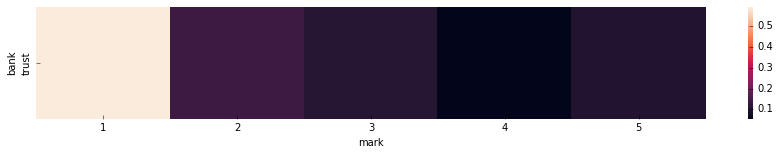

In [9]:
plt.figure(figsize=(15, 2))
heatmap(pd.crosstab(replies.bank, replies.mark[replies.mark != -1], normalize="index"))

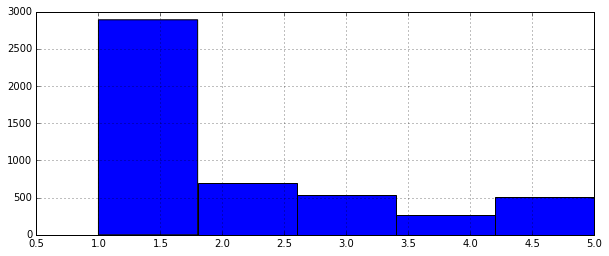

In [10]:
plt.figure(figsize=(10, 4))
replies.mark[replies.mark != -1].hist(bins=5)

Как часто пользователи пишут комментарии?

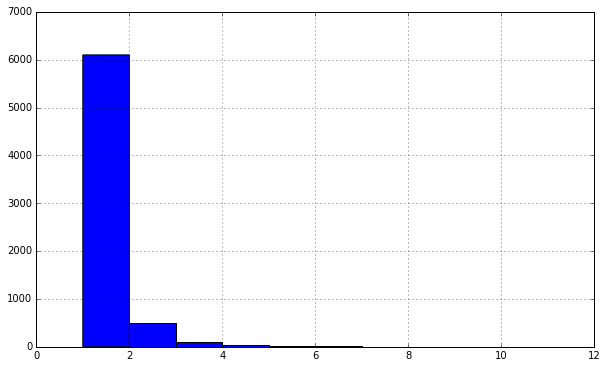

In [11]:
comment_frequency = replies.author.value_counts()
fig, ax = plt.subplots(figsize=(10, 6))
comment_frequency.hist(bins=10)

Большинство оставляют 1 комментарий, иногда 2,3. Посмотрим отдельно на активных пользователей.

In [12]:
pd.set_option("display.max_rows", 100)
replies[replies.author.isin(comment_frequency[comment_frequency > 5].index)].groupby(
    ["author"])["mark"].value_counts().unstack(fill_value=0).head(50)

mark,-1,1,2,3,4,5
author,,,,,,
DSV1968,2,1,0,0,0,3
Eduoleg,8,0,0,1,1,1
Lada2503,3,2,1,0,0,0
Lexx908,2,2,2,0,0,0
Tiran_25,7,1,0,1,0,0
aalisovoi,3,1,3,0,0,0
bekyural,4,2,0,0,0,0
dfimid866,3,3,0,1,0,0
new_user2,2,2,0,1,1,1


Оценки пользователей, которые поставили противоричивые отзывы

In [13]:
exc_authors = (replies[replies['mark'] == 5].author.value_counts() >= 1)
hor_authors = (replies[replies['mark'] == 1].author.value_counts() >= 1)
contradictory_authors = pd.Index([x for x in exc_authors.index.values if x in hor_authors.index.values])
print(contradictory_authors)
print(type(exc_authors.index))

Index([u'DSV1968', u'biruk', u'Mihelson', u'Dimson88', u'sledopyt23',
       u'dailyadm', u'koz1961', u'MaksimovMaksim', u'денис.', u'Моро3',
       u'ozzyback', u'podpruzhenko', u'egevlenko', u'pasha0001', u'login196',
       u'Станислав Александрович', u'ClientNSK', u'DDV86', u'new_user2',
       u'ЧУБА83', u'Dmitry___', u'sergeos', u'dmitry29', u'PAZZL', u'vik67',
       u'petrK'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


In [14]:
replies[replies.author.isin(contradictory_authors)].groupby(["author"])["mark"].value_counts().unstack(fill_value=0)

mark,-1,1,2,3,4,5
author,,,,,,
ClientNSK,1,2,0,0,0,1
DDV86,0,1,1,1,0,1
DSV1968,2,1,0,0,0,3
Dimson88,0,1,1,0,0,1
Dmitry___,0,1,0,0,0,1
MaksimovMaksim,2,1,0,0,0,1
Mihelson,0,1,0,0,0,1
PAZZL,0,1,0,0,0,1
biruk,0,1,0,0,0,2


Сильно ли отличаются даты этих комментариев? (Может банк решил проблему или же наоборот стало хуже с обслуживанием)

In [15]:
replies["time"] = pd.to_datetime(replies["time"])

In [16]:
contradictory_info = replies[replies.author.isin(contradictory_authors)]
contradictory_comment = contradictory_info[(contradictory_info['mark'] == 1) | (contradictory_info['mark'] == 5)].text
replies[replies.text.isin(contradictory_comment)].groupby(["author", "time"])["mark"].value_counts().unstack(fill_value=0)

mark                                         1  5
author                  time                     
ClientNSK               2012-02-13 19:55:00  1  0
                        2012-07-02 09:11:00  1  0
                        2012-11-07 08:22:00  0  1
DDV86                   2010-01-25 20:43:00  0  1
                        2010-04-20 22:17:00  1  0
DSV1968                 2013-03-06 20:00:00  0  1
                        2013-04-05 22:48:00  0  1
                        2013-08-19 18:52:00  0  1
                        2014-02-23 11:22:00  1  0
Dimson88                2014-11-07 23:29:00  0  1
                        2015-01-23 22:45:00  1  0
Dmitry___               2012-04-07 17:23:00  1  0
                        2014-06-21 15:59:00  0  1
MaksimovMaksim          2015-02-10 14:23:00  0  1
                        2015-08-17 12:42:00  1  0
Mihelson                2008-03-16 14:21:00  1  0
                        2009-08-11 14:32:00  0  1
PAZZL                   2009-09-28 17:53:00  1  0
                        2009-12-23 10:29:00  0  1
biruk                   2013-02-12 19:05:00  1  0
                        2015-03-04 20:53:00  0  1
                        2015-11-02 18:08:00  0  1
dailyadm                2012-09-24 21:23:00  0  1
                        2014-12-30 11:22:00  1  0
dmitry29                2011-10-08 11:34:00  1  0
                        2015-11-02 13:57:00  0  1
egevlenko               2012-11-14 10:58:00  0  1
                        2013-12-20 23:13:00  1  0
koz1961                 2011-10-03 15:04:00  0  1
                        2013-03-03 22:43:00  1  0
login196                2014-10-28 22:56:00  1  0
                        2015-06-18 21:34:00  0  1
new_user2               2009-06-15 17:55:00  0  1
                        2012-09-25 14:59:00  1  0
                        2014-09-16 09:11:00  1  0
ozzyback                2013-11-20 14:05:00  0  1
                        2013-12-14 19:17:00  1  0
pasha0001               2014-12-26 14:02:00  1  0
                        2015-01-20 11:30:00  0  1
petrK                   2013-06-13 23:31:00  0  1
                        2013-07-06 23:06:00  1  0
podpruzhenko            2012-08-30 20:50:00  0  1
                        2013-12-18 09:02:00  1  0
                        2017-01-14 10:05:00  1  0
sergeos                 2009-04-14 13:32:00  0  1
                        2010-02-25 18:31:00  1  0
sledopyt23              2011-07-21 06:39:00  0  1
                        2012-03-19 13:51:00  1  0
                        2012-12-13 20:05:00  1  0
vik67                   2009-12-18 22:42:00  0  1
                        2011-09-20 18:53:00  1  0
Моро3                   2012-08-24 19:27:00  0  1
                        2014-01-23 17:57:00  1  0
Станислав Александрович 2013-09-28 08:01:00  0  1
                        2015-11-15 17:37:00  1  0
ЧУБА83                  2016-07-24 20:48:00  1  0
                        2016-07-29 13:22:00  0  1
денис.                  2011-11-18 14:15:00  0  1
                        2013-01-30 18:43:00  1  0

## Преобразование данных в формат Vowpal Wabbit

Vowpal Wabbit базируется на следующих принципах:

* каждый документ записывается в одну строку
* все токены представлены в строковом формате (не требуется делать токенизацию)
* стадартная частота токенов = 1.0, чтобы ее изменить нужно указать ее значения после символа через двоеточие
* модальность токена идентифицируется символом (|)

#### Формат данных:
** `[<title>] [|@modality_class] {token[:counter]}` **

[Форматы входных данных](http://bigartm.readthedocs.io/en/stable/tutorials/datasets.html)

In [17]:
FOLDER_DATA = 'trust/'
FOLDER_BATCHES = FOLDER_DATA + 'batches/'

### Документ = предложение

**Пример строк входного файла:**

0  |@default_class когда:5 долгий:1 разница:1 спокойно:2 один:2 возможный:1 неизвестно:1

20  |@default_class перев:3 испробовать:1 деньги:3 сказать:1 открывать:1 один:1 первый:1

Нам потребуются два типа документов: отзыв, предложение.

Предложения будем формировать как объединение слов соответствующих ему синтаксических веток. Тем самым мы отнормируем вес слов в зависимости от их синтаксической значимости.

In [18]:
output_vw = []
for index, vw_dict in tqdm_notebook(sentences_replies.vw.dropna().iteritems()):
    sentence = [u"{}:{}".format(word, frequency) for word, frequency in vw_dict.iteritems()]
    output_vw.append(u"{} |@default_class {}".format(index, " ".join(sentence)))
    
with codecs.open(FOLDER_DATA + "vw_sentences.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

### Документ = отзыв

In [19]:
output_vw = []
current_reply_id = sentences_replies.iloc[0].reply_id
reply_words = dict()

for _, row in tqdm_notebook(sentences_replies[["vw", "reply_id"]].dropna().iterrows()):
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_replies.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

### VW для своего словаря тональностей

In [20]:
output_vw = []
current_reply_id = sentences_replies.iloc[0].reply_id
reply_words = dict()
sentiment_indexes = list(replies[replies.mark != -1].index)
sentences_replies_sentiment = sentences_replies[sentences_replies.reply_id.isin(sentiment_indexes)]

for _, row in tqdm_notebook(sentences_replies_sentiment[["vw", "reply_id"]].dropna().iterrows()):
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_sentiment.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

## WNTM псевдо-документы

абсурдный |@default_class абсолютно:8 авангард:1 адрес:5 альфа:1 аргумент:1 аргументировать:1 ассоциироваться:1 банк:22 банкомат:1 безобразие:1 бесплатный:2 

сопротивляться |@default_class активно:2 анкета:1 аннулирование:1 аргумент:1 банк:21 барышня:1 блокировка:1 более:2 брать:1 бухгалтер:1 бы:2 быдло:2 быть:7 ведь:1 вежливость:1

Входные аргументы:
- **lines** - список строк
- **output_dir** - куда положить выходные данные
- **window** - ширина окна

в **output_dir** будут:
- **vw_ww.txt** - псевдо-документы в vw формате
- **pmi.txt** - счетчики совстречаемости
- **vocab.txt** - словарь коллекции

In [21]:
prepare_vw_wntm_pmi_vocab(lines=branches.branch, output_dir=FOLDER_DATA, window=5)

100%|██████████| 529374/529374 [00:07<00:00, 68842.21it/s]


save wv to trust/ww_vw.txt



100%|██████████| 1543016/1543016 [00:04<00:00, 344783.31it/s]



save vocab to trust/vocab.txt

11603 from 11604
save pmi to trust/pmi.txt


Time elapsed: 47.602 sec.


# Тематическое моделирование

#### Цель экспериментов:
Выявить тематическую структуру отзывов и определить их тональности.

#### Описание
Построим тематические модели для отзывов и WNTM для коротких текстов. Проведем анализ тональности тем.

### Документ = отзыв
В данной группе экспериментов будем счить каждый отзыв отдельным документом

In [22]:
PATH_TO_VW_REPLIES = FOLDER_DATA + 'vw_replies.txt'
FOLDER_BATCHES_REPLIES = FOLDER_BATCHES + "replies"
PMI_PATH = FOLDER_DATA + "pmi.txt"
VOCAB_PATH = FOLDER_DATA + "vocab.txt"

Cоздадим объект BatchVectorizer:

In [23]:
bv = artm.BatchVectorizer(data_path=PATH_TO_VW_REPLIES, data_format="vowpal_wabbit",
                          target_folder=FOLDER_BATCHES_REPLIES, gather_dictionary=True)

In [24]:
def createTopics(domain_n=90, background_n=10, sentiment=False):
    global DOMAIN_N, BACKGROUND_N, string_id
    DOMAIN_N = domain_n
    BACKGROUND_N =  background_n
    string_id = "d{}_b{}".format(domain_n, background_n)
    global topics_background, topics_domain, topics_sentiment
    topics_domain = ['topic_d{}'.format(i) for i in xrange(domain_n - 2)]
    if sentiment:
        topics_sentiment = ['topic_pos', 'topic_neg']
    else:
        topics_domain += ['topic_d{}'.format(i) for i in xrange(domain_n - 2, domain_n)]
    
    topics_background = ['topic_b{}'.format(i) for i in xrange(background_n)]

Число тем выберем основываясь на размере коллекции.

In [25]:
createTopics(domain_n=100, background_n=10)

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эта матрица будет заполнена случайными значениями из диапазона **(**0, 1) и нормализована.

Словарь &ndash; это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.
[ARTM_model](http://bigartm.readthedocs.io/en/stable/api_references/python_interface/artm_model.html)

Если матрица $\Theta$ слишком большая, то следует выставить cache_theta=False, reuse_theta=False и изменить число проходов по документу num_document_passes=10. Так как матрица $\Theta$ не хранится в памяти, то BigARTM будет делать несколько итераций чтобы "получить ее по частям".

In [26]:
model = artm.ARTM(topic_names=topics_domain + topics_background, dictionary=bv.dictionary, 
                  theta_columns_naming="title", num_document_passes=1, cache_theta=True, reuse_theta=True)

Основным функционалом качества является перплексия коллекции. Однако это не иденственный функционал качества. Будем смотреть на следюущие характеристики тематической модели:
- разреженность матрицы $\Phi$ (слова-темы); 
- разреженность матрицы $\Theta$ (темы-документы);
- характеристики ядер тем (чистота, контрастность, размер);
- когерентность $\mathsf{PMI}_t =\frac{2}{k(k-1)} \sum_{i=1}^{k-1} \sum_{j=i}^k \mathsf{PMI} (w_i,w_j)$

[Метрики качества](http://bigartm.readthedocs.io/en/stable/tutorials/scores_descr.html)

In [27]:
def add_scores(model):
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                  dictionary=cooc_dict))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', topic_names=topics_domain))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', topic_names=topics_domain))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                           topic_names=topics_domain, probability_mass_threshold=0.3))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                         num_tokens=50, dictionary=cooc_dict))

Соберем словарь совстречаемостей для подсчета когерентности тем:

In [28]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(data_path=FOLDER_BATCHES_REPLIES, cooc_file_path=PMI_PATH, vocab_file_path=VOCAB_PATH)

Для оценки качества будем смотреть на графики метрик качества в зависимости от итерации.

In [29]:
def plot(model, savefig=False):
    x = range(len(model.score_tracker['PerplexityScore'].value[1:]))
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'convergence{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['TopTokensScore'].average_coherence[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Coherence top50', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'interpretability{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    plt.show()
    plt.clf()

Для оценки **интерпретируемости** тем будем смотреть на топ-токены.

In [30]:
def printTopics(model, topics, num=70, print_file=False):
    phi = model.get_phi()
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics):
        topicSeries = phi[topic].sort_values(ascending=False)[:num]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        string_to_print += topic + ":[{}/{}] ".format(len(result), sum(phi[topic] > 0)) + " ".join(result) + "\n"
        zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER_DATA + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

In [31]:
add_scores(model)

In [32]:
%timeit model.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

1 loop, best of 3: 5 s per loop


График перплексии показывает, что модель еще не сошлась.

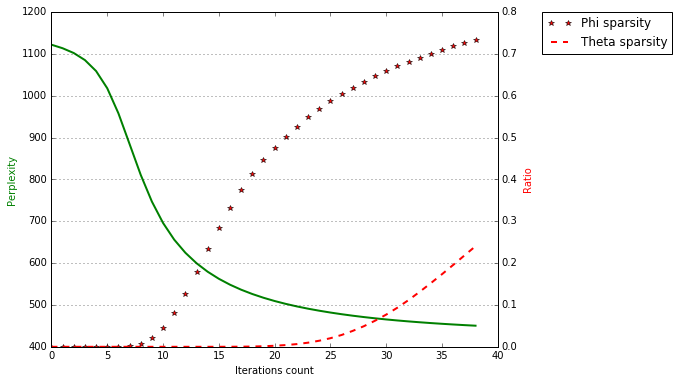

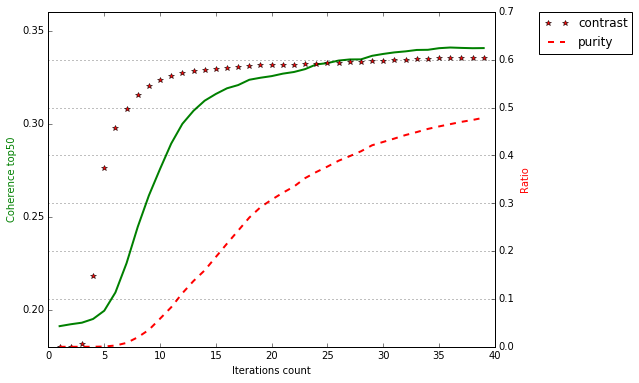

In [33]:
plot(model)

In [34]:
%timeit model.fit_offline(batch_vectorizer=bv, num_collection_passes=15)

1 loop, best of 3: 8.42 s per loop


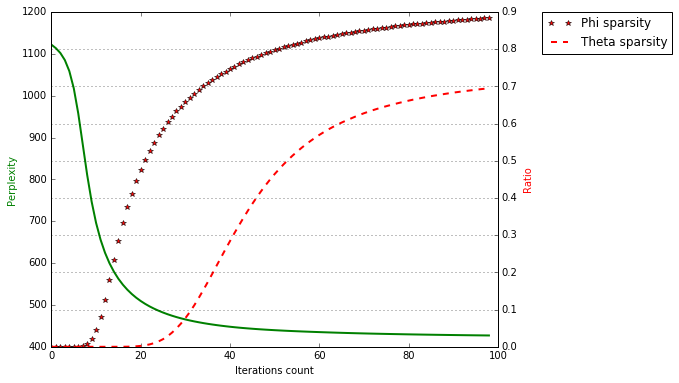

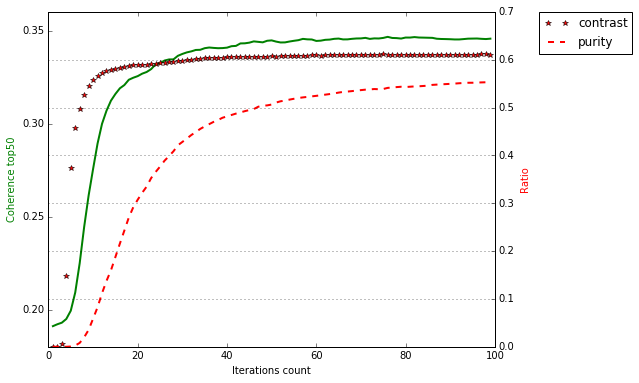

In [35]:
plot(model)

In [36]:
printTopics(model, topics_domain + topics_background)

topic_d0:[70/1460] операция приводить банк тариф разъяснять устанавливать существовать клиент поддержка средство служба информация курс условие осуществляться комиссия продукт онлайн ограничивать не проведение перевод интернет конвертация сайт осуществлять валюта предоставление случай система ответ покупка рубль поддержка_служба который правило это то овердрафт счет п совершать снятие ссылка денежный течение включать использование день консультант этот данный расходный ваш операция_совершать обслуживание банковский же баланс возможный связь отдел практика отсутствие ограничение безналичный оплата увеличение изменение соответствие
topic_d1:[70/1519] банкомат невозможно принимать город деньги не купюра терминал ул набирать банк отделение кассир сбой работа касса проблема прием адрес один д технический наличный только год добираться новгород чек время г внесение съедать этот срок раз располагать сломаться плата единственный наказываться день тся отпрашиваться функция зажевать нижний надпи

После того как модель сошлась, потребуем от модели различность предметных тем. Для этого добавим декоррелирующий регуляризатор. Более того добавим регуляризатор сглаживания фоновых тем.

[Описание регуляризаторов](https://bigartm.readthedocs.io/en/stable/api_references/python_interface/regularizers.html)

In [37]:
import copy
model_copy = copy.deepcopy(model)

In [38]:
model = copy.deepcopy(model_copy)

In [39]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=50000, topic_names=topics_domain))

In [40]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=20)

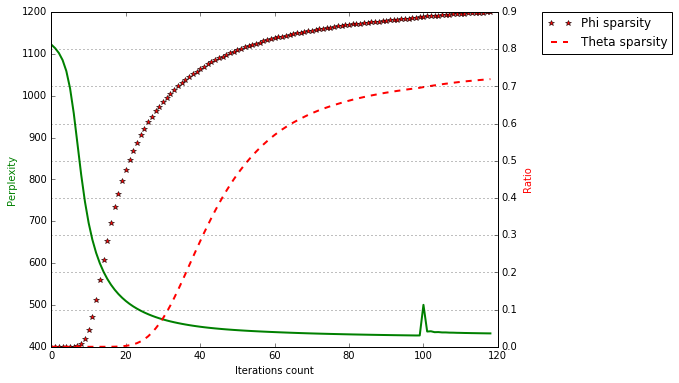

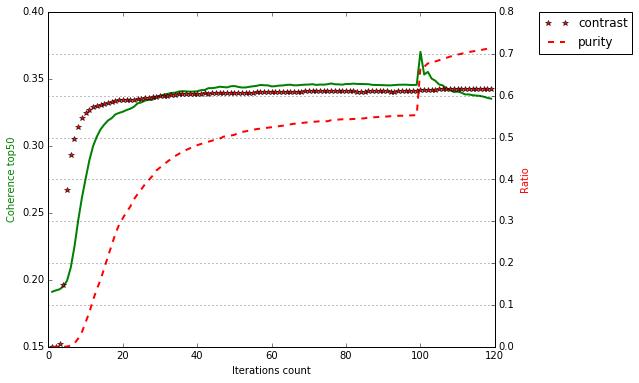

In [41]:
plot(model)

Посмотрим на топ-токены тем. На первый взгляд, темы являются интерпретируемыми.

In [42]:
Phi = model.get_phi()
printTopics(model, topics_domain + topics_background)

topic_d0:[70/1323] операция приводить тариф разъяснять устанавливать существовать поддержка курс служба осуществляться продукт информация ограничивать средство условие проведение конвертация случай осуществлять онлайн покупка валюта интернет предоставление комиссия поддержка_служба сайт правило система овердрафт ссылка консультант операция_совершать п использование расходный включать возможный практика течение банковский проводиться отдел безналичный рубль ответ снятие связь баланс сложно доступный евро равный увеличение обслуживание оплата совпадать фраза называться осуществление соответствие ограничение денежный далее страница перевод напутывать взимать магазин отсутствие
topic_d1:[70/1363] банкомат невозможно город принимать купюра ул терминал деньги набирать кассир сбой касса адрес прием д технический работа чек наличный добираться новгород съедать проблема внесение только сломаться единственный располагать наказываться вставлять зажевать нижний надпись отпрашиваться функция дом пл

Посмотрим на вклад тем в оценку отзывов. Видим, что некоторые темы хорошо скорелированы с оценками пользователей.

Далее, направим усилия на то чтобы вытянуть тональность в отдельные темы.

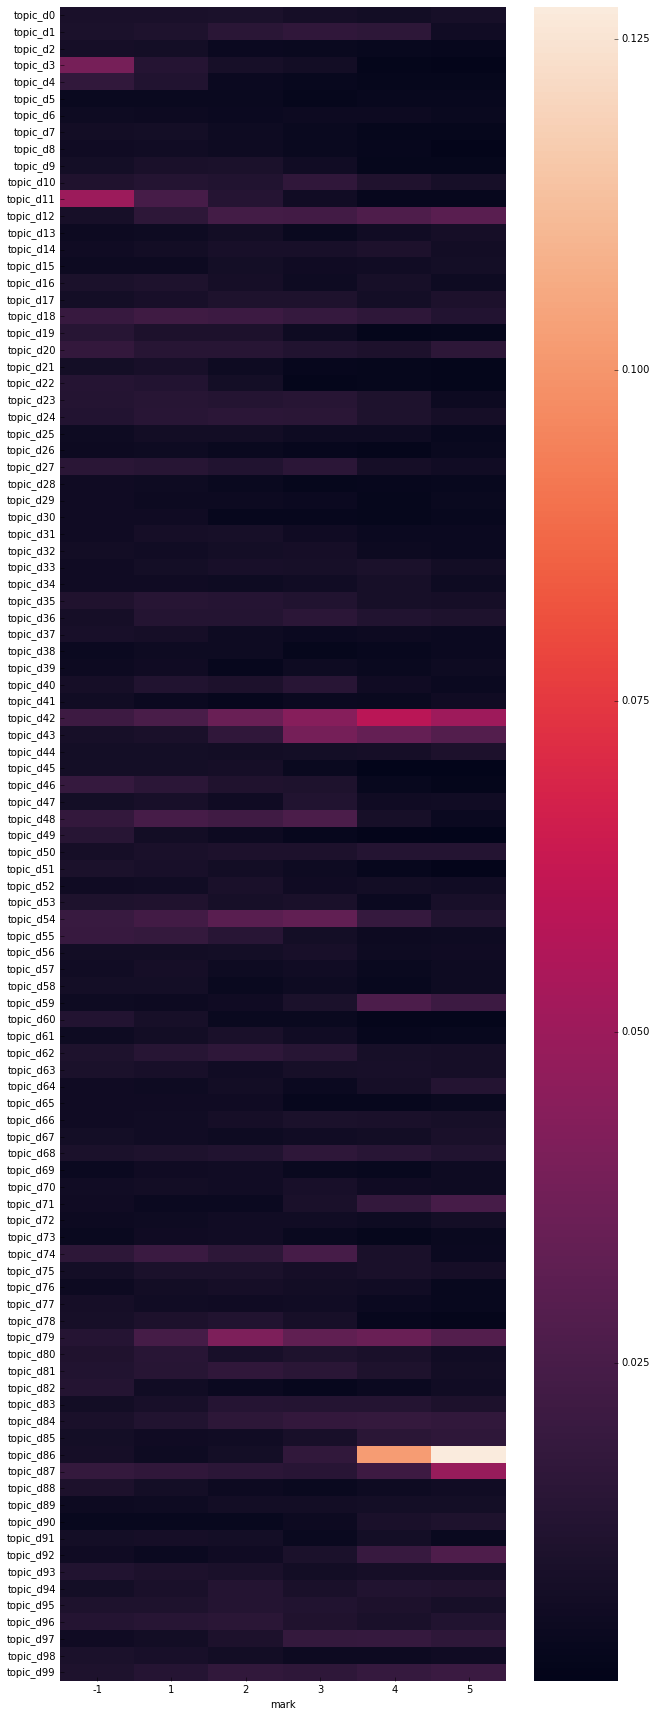

In [43]:
theta = model.get_theta()
theta = theta.transpose()[topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

## Добавим словарь тональностей

Воспользуемся общедоступным словарем тональностей [LINES CROWD](http://linis-crowd.org)

Каждое слово в словаре имеет несколько оценок тональности, выражаемых целыми числами от -2 до 2.

Сделаем лемматизацию словаря для того чтобы множество его слов солгасовывалось со словарем тематической модели.

In [44]:
sentiment = pd.read_excel("trust/collection_(docs_words)_2016_all_labels/full word_rating_after_coding.xlsx", 
                          header=None)
mystem = Mystem()
sentiment[0] = sentiment[0].apply(lambda word: lemmatize(word, mystem)[0])
sentiment.head(10)

,0,1
0,абажур,0
1,абажур,0
2,абажур,-1
3,абориген,-1
4,абориген,-1
5,абориген,0
6,аборт,-2
7,аборт,0
8,аборт,-1
9,аборт,0


Для каждого слова из словаря усредним и отнормируем его оценки тональности.

In [45]:
sentiment = sentiment.groupby(0).mean()
sentiment.columns = ["value"]
sentiment.value /= 2

Отберем тональные слова, встречающиеся в словаре тематической модели.

In [46]:
import codecs
with codecs.open(VOCAB_PATH, "r", "utf-8") as f:
    vocab = set(f.read().splitlines())

In [47]:
indexes = set(sentiment.index) & vocab
sentiment = sentiment.loc[indexes]
positive = set(sentiment[sentiment.value > 0].index)
negative = set(sentiment[sentiment.value < 0].index)
sentiment_dict = positive | negative
print "Всего тональных слов {}, из них положительной тональности - {}, \
отрицательной - {}".format(sum(sentiment.value != 0), len(positive), len(negative))

Всего тональных слов 1865, из них положительной тональности - 671, отрицательной - 1194


### Разделим словарь на две части: тональные и не тональные слова.

In [48]:
bv.dictionary.save_text(FOLDER_DATA + "all.txt")

Составим тональный словарь. Тональным словам зададим вес согласно словарю, остальным словам зададим вес равный нулю.

In [49]:
ethnic_dict_name = 'sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(sentiment.loc[token].value)  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_sentiment = artm.Dictionary()
dictionary_sentiment.create(dictionary_data)

os.remove(FOLDER_DATA + ethnic_dict_name + ".dict") if os.path.exists(FOLDER_DATA + ethnic_dict_name + ".dict") else None
dictionary_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

os.remove(FOLDER_DATA + ethnic_dict_name + ".txt") if os.path.exists(FOLDER_DATA + ethnic_dict_name + ".txt") else None
dictionary_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 10933


Составим словарь с нетональными словами. Тональным словам зададим вес равный нулю, у остальных слов не будем изменять вес.

In [50]:
ethnic_dict_name = 'non_sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(abs(sentiment.loc[token].value))  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_non_sentiment = artm.Dictionary()
dictionary_non_sentiment.create(dictionary_data)

os.remove(FOLDER_DATA + ethnic_dict_name + ".dict") if os.path.exists(FOLDER_DATA + ethnic_dict_name + ".dict") else None
dictionary_non_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

os.remove(FOLDER_DATA + ethnic_dict_name + ".txt") if os.path.exists(FOLDER_DATA + ethnic_dict_name + ".txt") else None
dictionary_non_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 10933


In [51]:
createTopics(domain_n=100, background_n=10, sentiment=True)

In [52]:
model_sentiment = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)

In [53]:
add_scores(model_sentiment)

Потребуем от модели, чтобы тональные слова собрались в двух темах. Для этого будем сглаживать тональные темы по тональному словарю и разреживать предметные по словарю нетональных слов.

In [54]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-10000))

In [55]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=40)

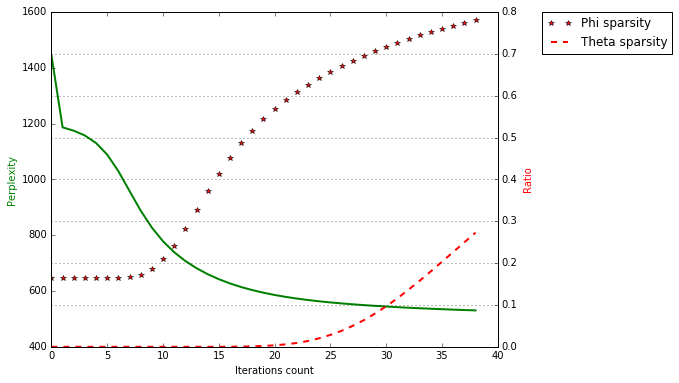

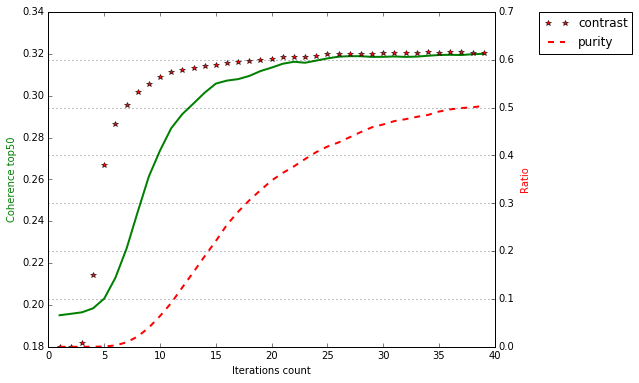

In [56]:
plot(model_sentiment)

Посмторим на топ-токены, тональные слова собрались в первых двух темах.

In [57]:
Phi = model_sentiment.get_phi()
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/640] имя сотрудник смочь писать нужный вернуть помогать одобрять касса надеяться возможность добрый новый подписывать понравиться хороший открытие спасибо страховка наш интересный приятный довольный отзывчивый гениальный искать всегда здравствовать встречать поддержка впечатление вежливый решаться согласный нравиться рекомендовать подождать удобный уважение возврат желать волшебный разный любить ура безупречный надежда искренний красавица шикарный радовать захотеть интересовать пожалуйста уникальный доброжелательный правда удивительный знание милый праздничный важный компетентный прекрасный исправлять дар стараться нормальный конструктивный позитивный
topic_neg:[70/1164] заявление указывать пытаться пользоваться проблема много начинаться отказываться оставлять разбираться срок выясняться передавать занимать забирать сидеть списывать заплатить штраф долг претензия проводить заявлять выплачивать никакой лицо отдавать нарушать потратить продолжать забывать жалоба ошибка отка

In [58]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=50000, topic_names=topics_domain))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=500, topic_names=topics_sentiment))

In [59]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

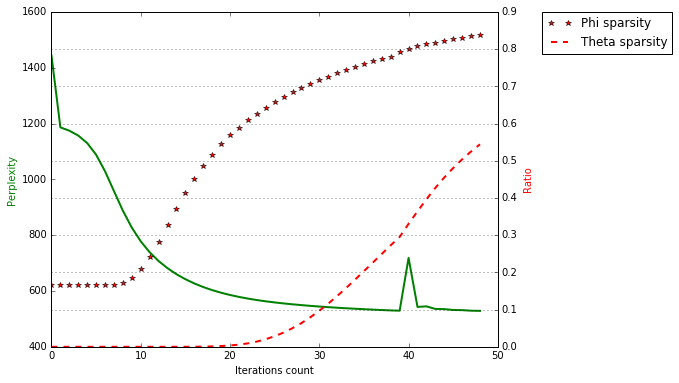

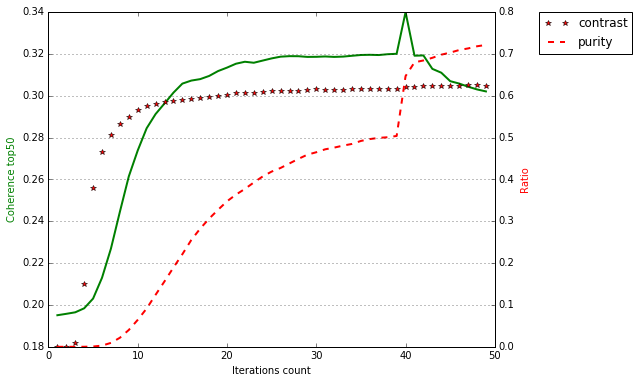

In [60]:
plot(model_sentiment)

In [61]:
Phi = model_sentiment.get_phi()
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/640] имя сотрудник смочь писать нужный вернуть помогать одобрять касса надеяться возможность добрый новый подписывать понравиться хороший открытие спасибо страховка наш интересный приятный довольный отзывчивый гениальный искать всегда здравствовать встречать поддержка впечатление вежливый решаться согласный нравиться рекомендовать подождать удобный уважение возврат желать волшебный разный любить ура безупречный надежда искренний красавица шикарный радовать захотеть интересовать пожалуйста уникальный доброжелательный правда удивительный знание милый праздничный важный компетентный прекрасный исправлять дар стараться нормальный конструктивный позитивный
topic_neg:[70/1164] заявление указывать пытаться пользоваться проблема много начинаться отказываться оставлять разбираться срок выясняться передавать занимать забирать сидеть списывать заплатить штраф долг претензия проводить заявлять выплачивать никакой лицо отдавать нарушать потратить продолжать забывать жалоба ошибка отка

Как видим тональные слова сконцентрировались в тональных темах, что и требовалось от модели.

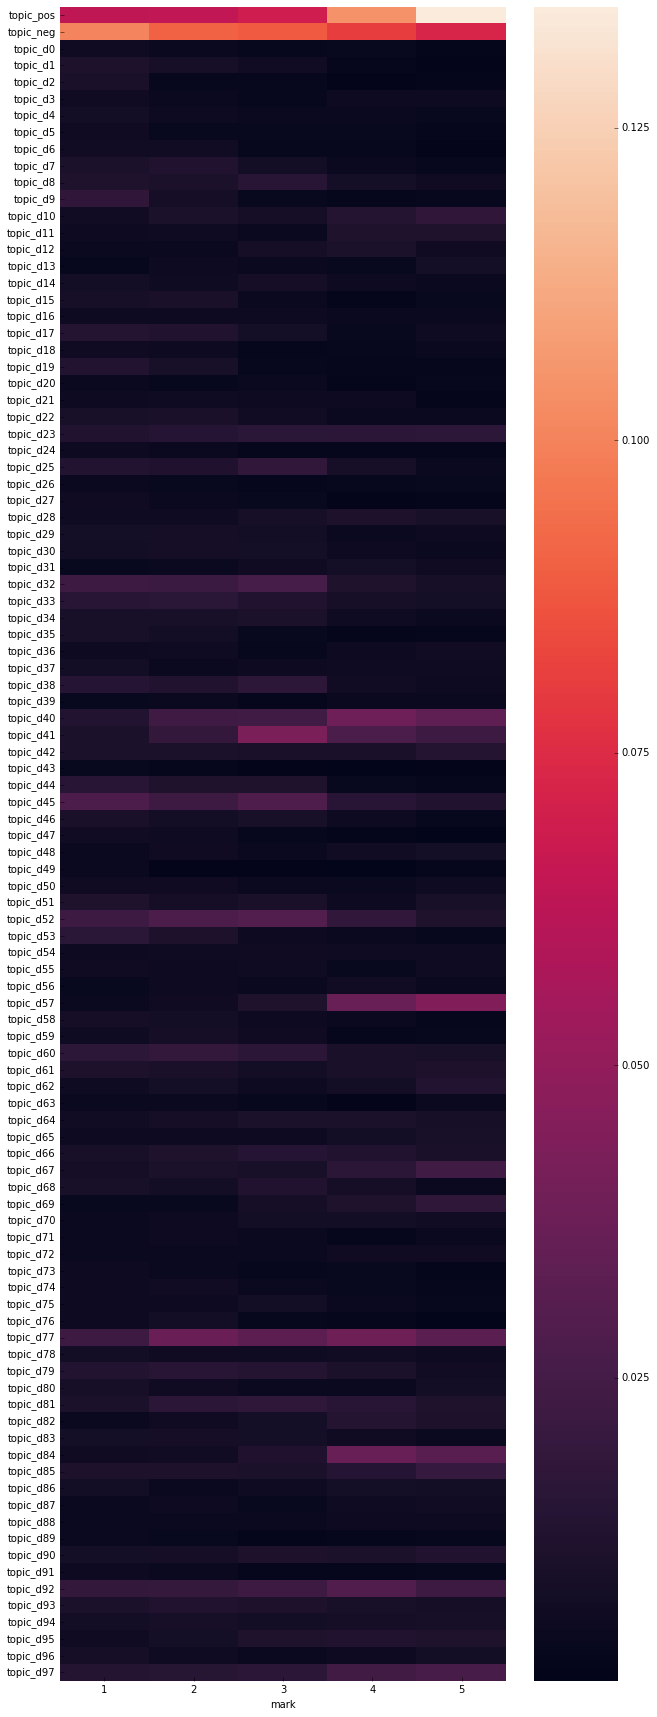

In [62]:
theta = model_sentiment.get_theta()
theta = theta.transpose()[topics_sentiment + topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
theta = theta[theta.mark != -1]
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

Вытянем матрицу $\Theta$ из модели. Проигнорируем фоновые темы и перенормируем матрицу.

In [63]:
theta = model_sentiment.get_theta().loc[topics_sentiment + topics_domain]
theta = theta.divide(theta.sum(axis=0), axis=1)
banks = { bank: index for index, bank in enumerate(replies.bank.unique())}

Оценим тональности $s$ предметной темы $t$ для банка $b$. 

$p(t_s | b, t) =   \frac{1}{|D|}\sum_{d \in D} p(t = t_s | b, d) * p(t | b, d) [p(t = t_s | b, d) > 0.1, p(t | b, d) > 0.1]$,

где $D$ --- множество отзывов.

P.S.
- тут явные проблемы с обозначениями/вероятностным пространством. Оставим эту формулу в качестве эвристики для лучшего понимания.
- можно код переписать слишком неоптимально.

In [64]:
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))
for index, row in tqdm_notebook(theta.transpose().iterrows()):
    positive = row.topic_pos
    negative = row.topic_neg
    if positive > 0.1 or negative > 0.1:
        selected = row[topics_domain][row > 0.1]
        if len(selected) > 0:
            for topic in selected.index:
                bank = banks[replies.loc[int(index)].bank]
                topic_influence = selected[topic]
                topic = int(topic.split("_")[1][1:])
                sentiment = np.argmax(row[topics_sentiment])
                if sentiment == "topic_pos":
                    sentiment = 0
                    sentiment_value = positive
                else:
                    sentiment = 1
                    sentiment_value = negative
                bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                bank_topic_sentiment[bank, topic, 2] += 1

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Оценим положительность окраса предметной темы $t$ для банка $b$ если число отзывов > 10

## $\frac{p(t_{+} | b, t)}{p(t_{+} | b, t) + p(t_{-} | b, t)}$

In [65]:
bank_topic = np.zeros(((len(banks), len(topics_domain))))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

In [66]:
# Phi = model.get_phi()
def printTopics(topics, num=70, print_file=False):
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics):
        topicSeries = Phi[topic].sort_values(ascending=False)[:num]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        string_to_print += topic + ":[{}/{}] ".format(len(result), sum(Phi[topic] > 0)) + " ".join(result) + "\n"
        zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER_DATA + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

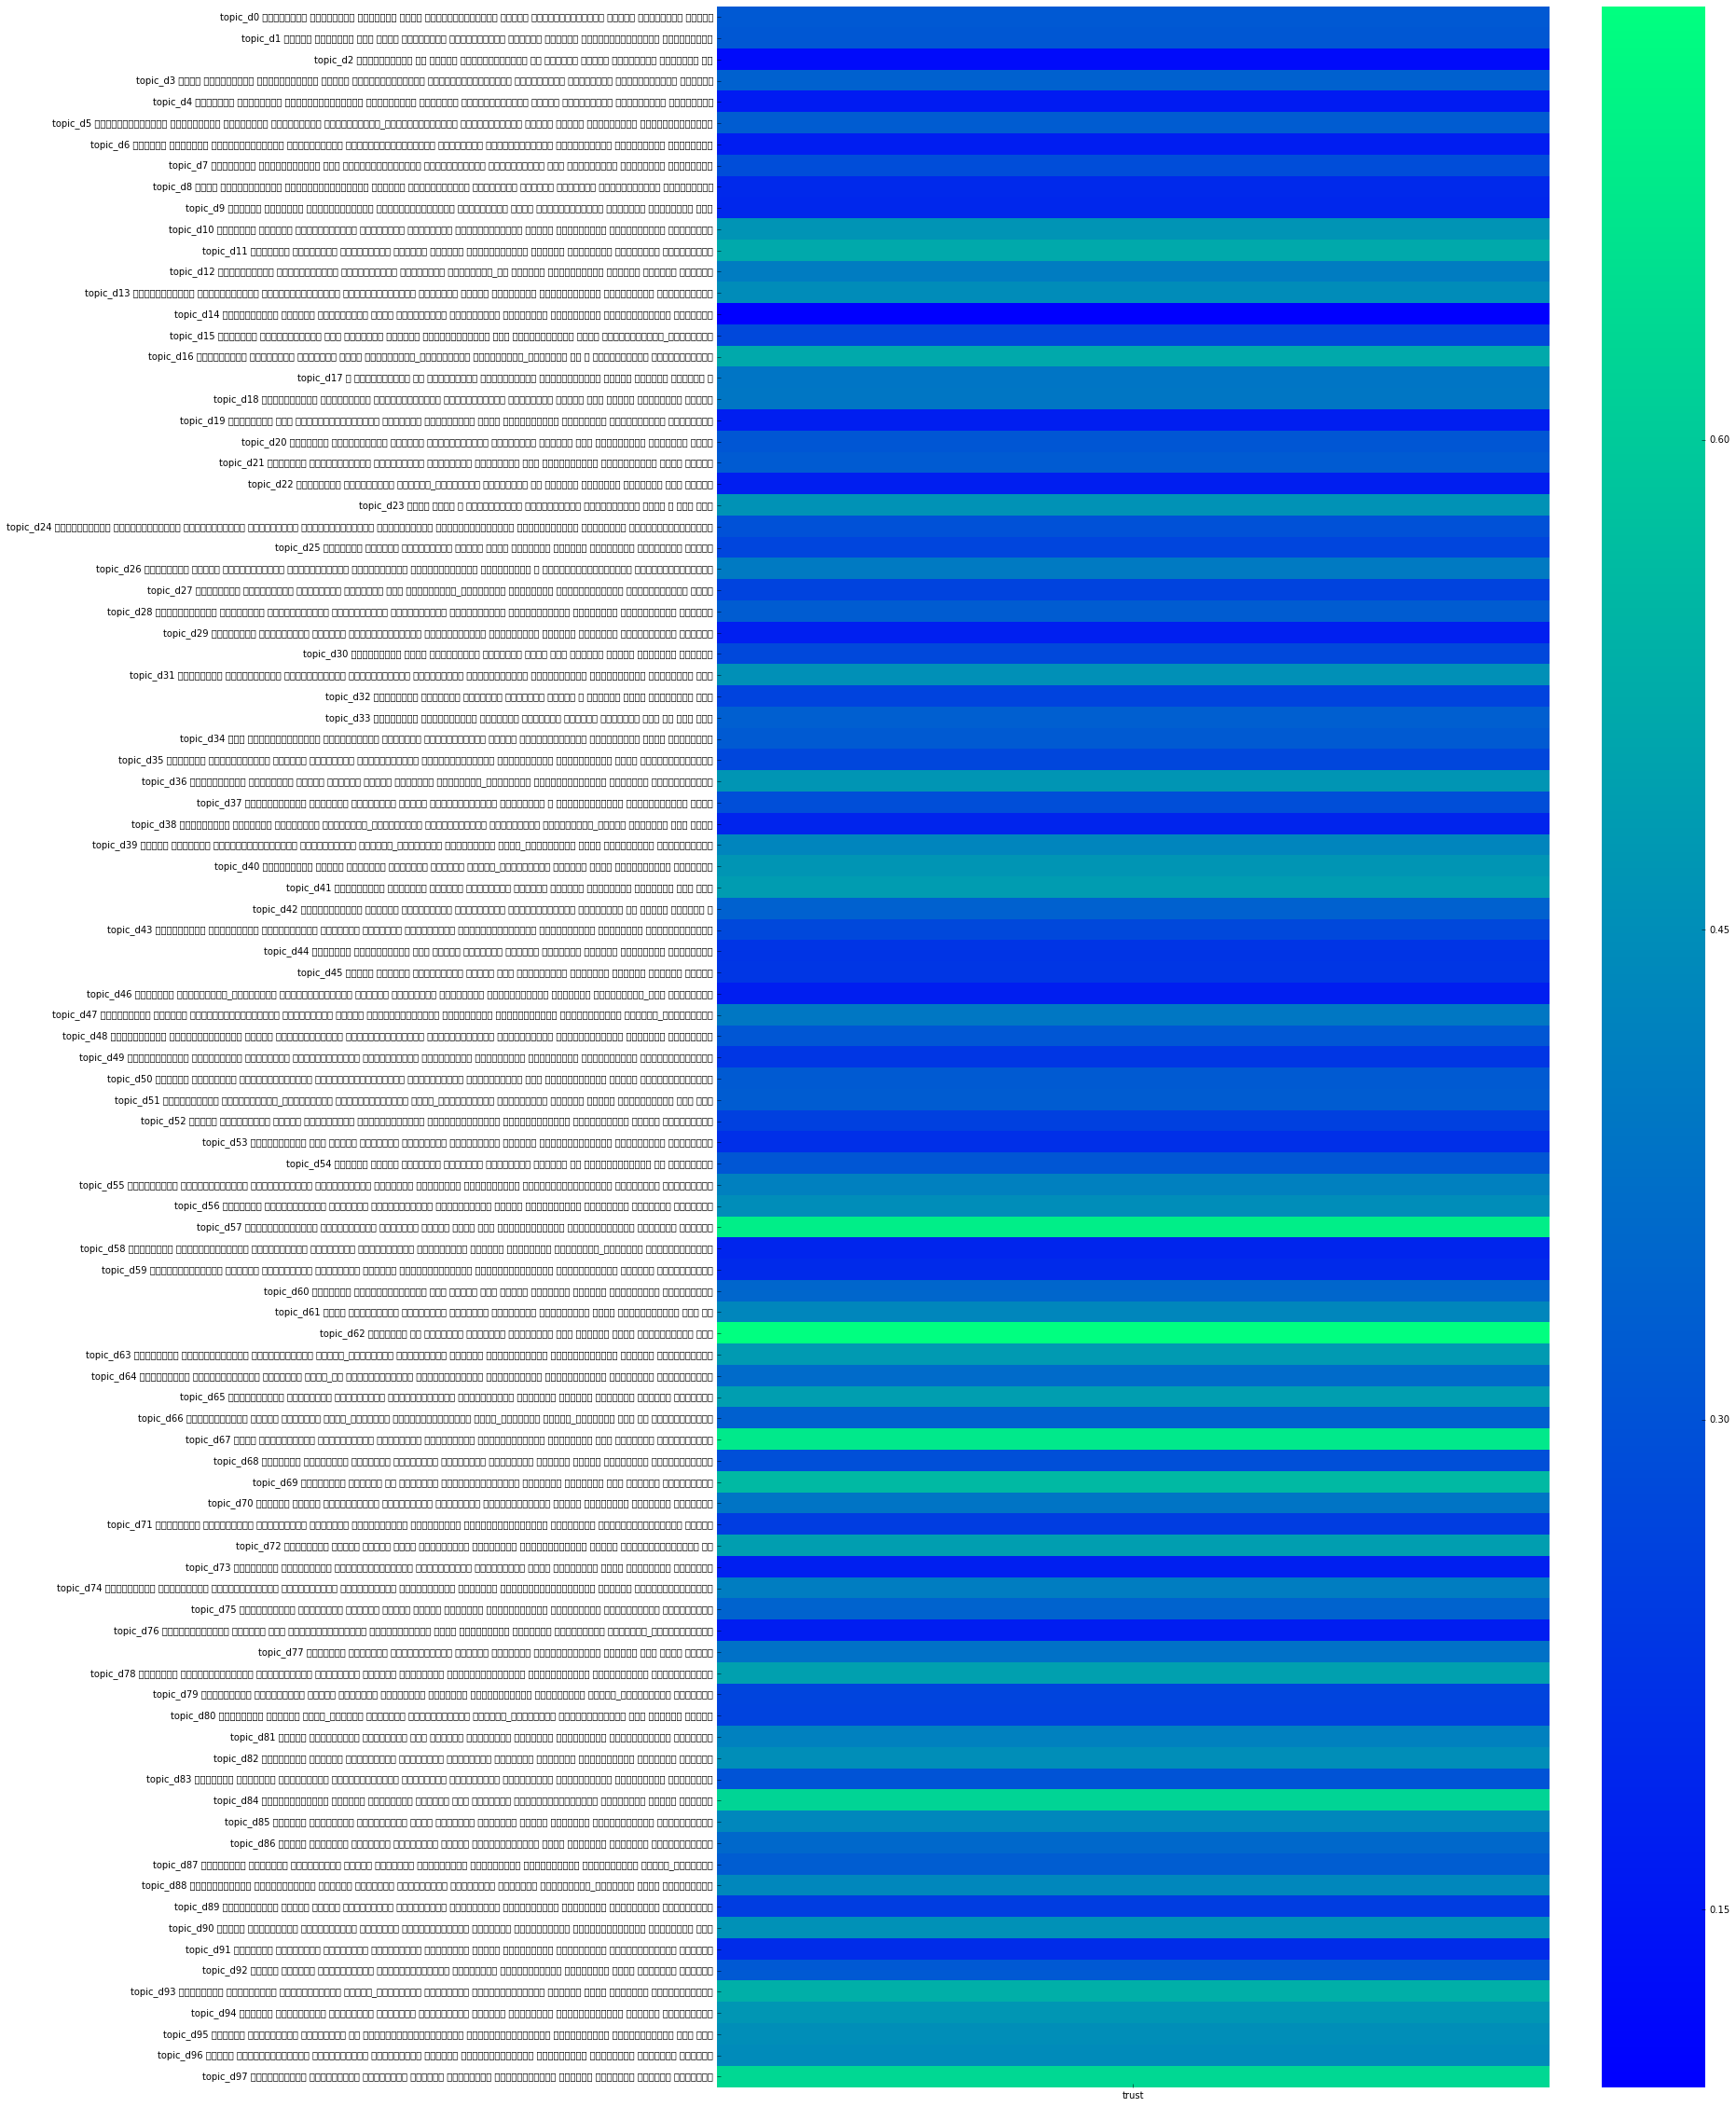

In [67]:
plt.figure(figsize=(20, 40))
data_bank = pd.DataFrame(bank_topic.transpose())
data_bank.columns = [key for key, value in sorted(banks.items(), key=lambda x:x[1]) if not_null_columns[value]]
description = []
Phi = model_sentiment.get_phi()
for i, topic in enumerate(topics_domain):
        topicSeries = Phi[topic].sort_values(ascending=False)[:10]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        #print result
        #res_u = [r for r in result]
        #print res_u
        description.append(topic + " " + " ".join(result))
data_bank.index = description
heatmap(data_bank , cmap="winter")
plt.savefig("banks_sentiment_replies.png")

In [68]:
printTopics(topics=topics_sentiment + topics_domain, print_file=True)

topic_pos:[70/640] имя сотрудник смочь писать нужный вернуть помогать одобрять касса надеяться возможность добрый новый подписывать понравиться хороший открытие спасибо страховка наш интересный приятный довольный отзывчивый гениальный искать всегда здравствовать встречать поддержка впечатление вежливый решаться согласный нравиться рекомендовать подождать удобный уважение возврат желать волшебный разный любить ура безупречный надежда искренний красавица шикарный радовать захотеть интересовать пожалуйста уникальный доброжелательный правда удивительный знание милый праздничный важный компетентный прекрасный исправлять дар стараться нормальный конструктивный позитивный
topic_neg:[70/1164] заявление указывать пытаться пользоваться проблема много начинаться отказываться оставлять разбираться срок выясняться передавать занимать забирать сидеть списывать заплатить штраф долг претензия проводить заявлять выплачивать никакой лицо отдавать нарушать потратить продолжать забывать жалоба ошибка отка

## WNTM

In [69]:
PATH_TO_WW_VW = FOLDER_DATA + 'ww_vw.txt'
FOLDER_BATCHES_WW = FOLDER_DATA + 'batches_wntm/'

Подготовим батчи

In [70]:
bv_ww = artm.BatchVectorizer(data_path=PATH_TO_WW_VW, data_format='vowpal_wabbit',
                             target_folder=FOLDER_BATCHES_WW)

Добавим метрики качества

In [71]:
createTopics(domain_n=100, background_n=10, sentiment=True)

Инициализируем модель

In [72]:
model_vw = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                     theta_columns_naming="title", num_document_passes=1, cache_theta=True, reuse_theta=True)
add_scores(model_vw)

In [73]:
dictionary_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "sentiment.dict")
dictionary_non_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "non_sentiment.dict")

In [74]:
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=1000))
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-1000))
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-10000))

In [75]:
model_vw.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=40)

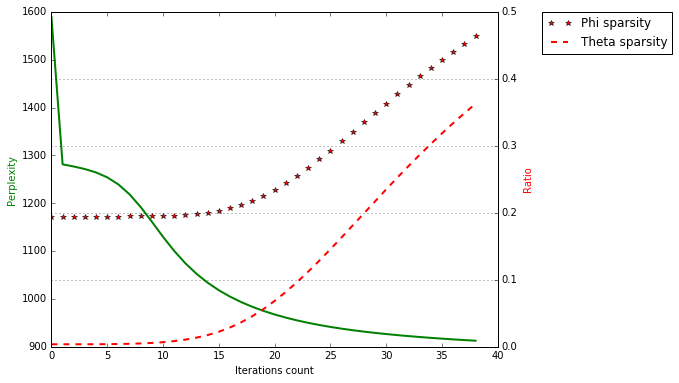

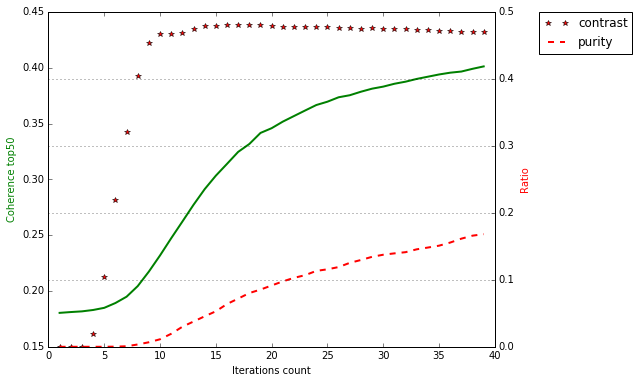

In [76]:
plot(model_vw)

In [77]:
Phi = model_vw.get_phi()
printTopics(topics_sentiment + topics_domain)

topic_pos:[70/3868] сотрудник смочь указывать пользоваться писать отказываться нужный помогать вернуть одобрять возможность проводить страховка надеяться подписывать новый спасибо открытие хороший возврат покупка касса наш понравиться довольный встречать искать впечатление поддержка нравиться решаться интересный рекомендовать подождать удобный желать помощь добрый всегда интересовать приятный доход здравствовать согласный увеличивать мобильный захотеть исправлять подпись важный вежливый расчет разный извиняться надежда принадлежать стараться уметь дом россия маленький увеличиваться любить бонус положительный внимание обязательство сделка правда радовать
topic_neg:[70/1484] заявление проблема пытаться оставлять много срок разбираться начинаться передавать списывать выясняться лицо претензия заявлять заплатить отказ сидеть долг занимать забирать никакой забывать продолжать нарушать выплачивать ошибка штраф попытка потратить отдавать жить нарушение жалоба результат отсутствовать конец зап

In [78]:
model_vw.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_vw.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_vw.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=200000, topic_names=topics_domain))
model_vw.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=2000, topic_names=topics_sentiment))

In [79]:
model_vw.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=10)

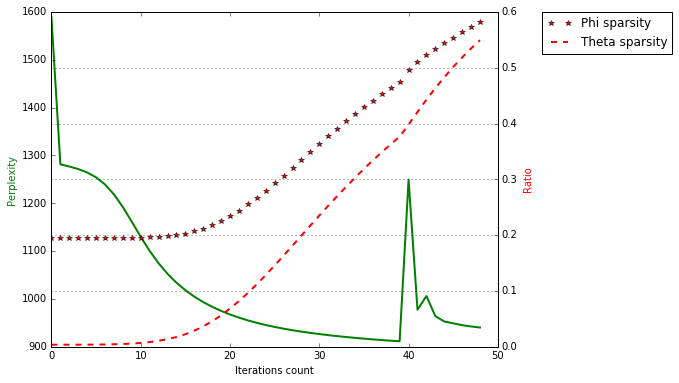

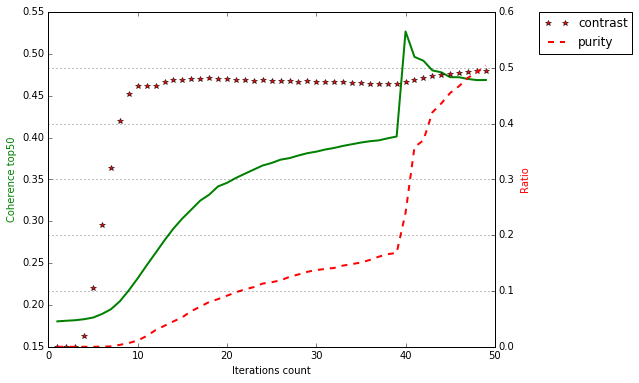

In [80]:
plot(model_vw)

In [81]:
Phi = model_vw.get_phi()
printTopics(topics_sentiment + topics_domain)

topic_pos:[70/2004] сотрудник смочь указывать пользоваться писать отказываться нужный помогать вернуть одобрять возможность проводить страховка надеяться подписывать новый спасибо открытие хороший возврат покупка касса наш понравиться довольный встречать искать впечатление поддержка нравиться решаться интересный рекомендовать подождать удобный желать помощь добрый всегда интересовать приятный доход здравствовать согласный увеличивать мобильный захотеть исправлять подпись важный вежливый расчет разный извиняться надежда принадлежать стараться уметь дом россия маленький увеличиваться любить бонус положительный внимание обязательство сделка правда радовать
topic_neg:[70/1170] заявление проблема пытаться оставлять много срок разбираться начинаться передавать списывать выясняться лицо претензия заявлять заплатить отказ сидеть долг занимать забирать никакой забывать продолжать нарушать выплачивать ошибка штраф попытка потратить отдавать жить нарушение жалоба результат отсутствовать конец зап

In [82]:
PATH_TO_WW_SENTENCES = FOLDER_DATA + 'vw_sentences.txt'
FOLDER_BATCHES_SENTENCES = FOLDER_BATCHES + 'sentences/'

In [83]:
num = 10
with codecs.open(PATH_TO_WW_SENTENCES, encoding="utf-8") as input_vw:
    lines = input_vw.read().splitlines()
    lines_n = len(lines)
    part = lines_n / num
    for i in tqdm_notebook(xrange(num)):
        with codecs.open(FOLDER_DATA + 'vw_sentences_{}.txt'.format(i), "w", encoding="utf-8") as output_vw:
            print >> output_vw, "\n".join(lines[part * i : part * (i + 1)])

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

In [84]:
banks = { bank: index for index, bank in enumerate(replies.bank.unique())}
bank_topic_sentiment = np.zeros(((len(banks), len(topics_domain), 3)))

In [85]:
for i in tqdm_notebook(xrange(10)):
    PATH_TO_WW_SENTENCES = FOLDER_DATA + 'vw_sentences_{}.txt'.format(i)
    FOLDER_BATCHES_SENTENCES = FOLDER_BATCHES + 'sentences_{}/'.format(i)
    bv_sentences = artm.BatchVectorizer(data_path=PATH_TO_WW_SENTENCES, data_format='vowpal_wabbit', batch_size=10000,
                                        target_folder=FOLDER_BATCHES_SENTENCES)
    theta_sentences = model_vw.transform(bv_sentences)

    theta = theta_sentences.loc[topics_sentiment + topics_domain]
    theta = theta.divide(theta.sum(axis=0), axis=1)

    for index, row in tqdm_notebook(theta.transpose().iterrows()):
        positive = row.topic_pos
        negative = row.topic_neg
        if positive > 0.3 or negative > 0.3:
            selected = row[topics_domain][row > 0.3]
            if len(selected) > 0:
                for topic in selected.index:
                    bank = banks[replies.loc[sentences_replies.loc[int(index)].reply_id].bank]
                    topic_influence = selected[topic]
                    topic = int(topic.split("_")[1][1:])
                    sentiment = np.argmax(row[topics_sentiment])
                    if sentiment == "topic_pos":
                        sentiment = 0
                        sentiment_value = positive
                    else:
                        sentiment = 1
                        sentiment_value = negative
                    bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                    bank_topic_sentiment[bank, topic, 2] += 1

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [86]:
bank_topic = np.zeros(((len(banks), len(topics_domain))))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

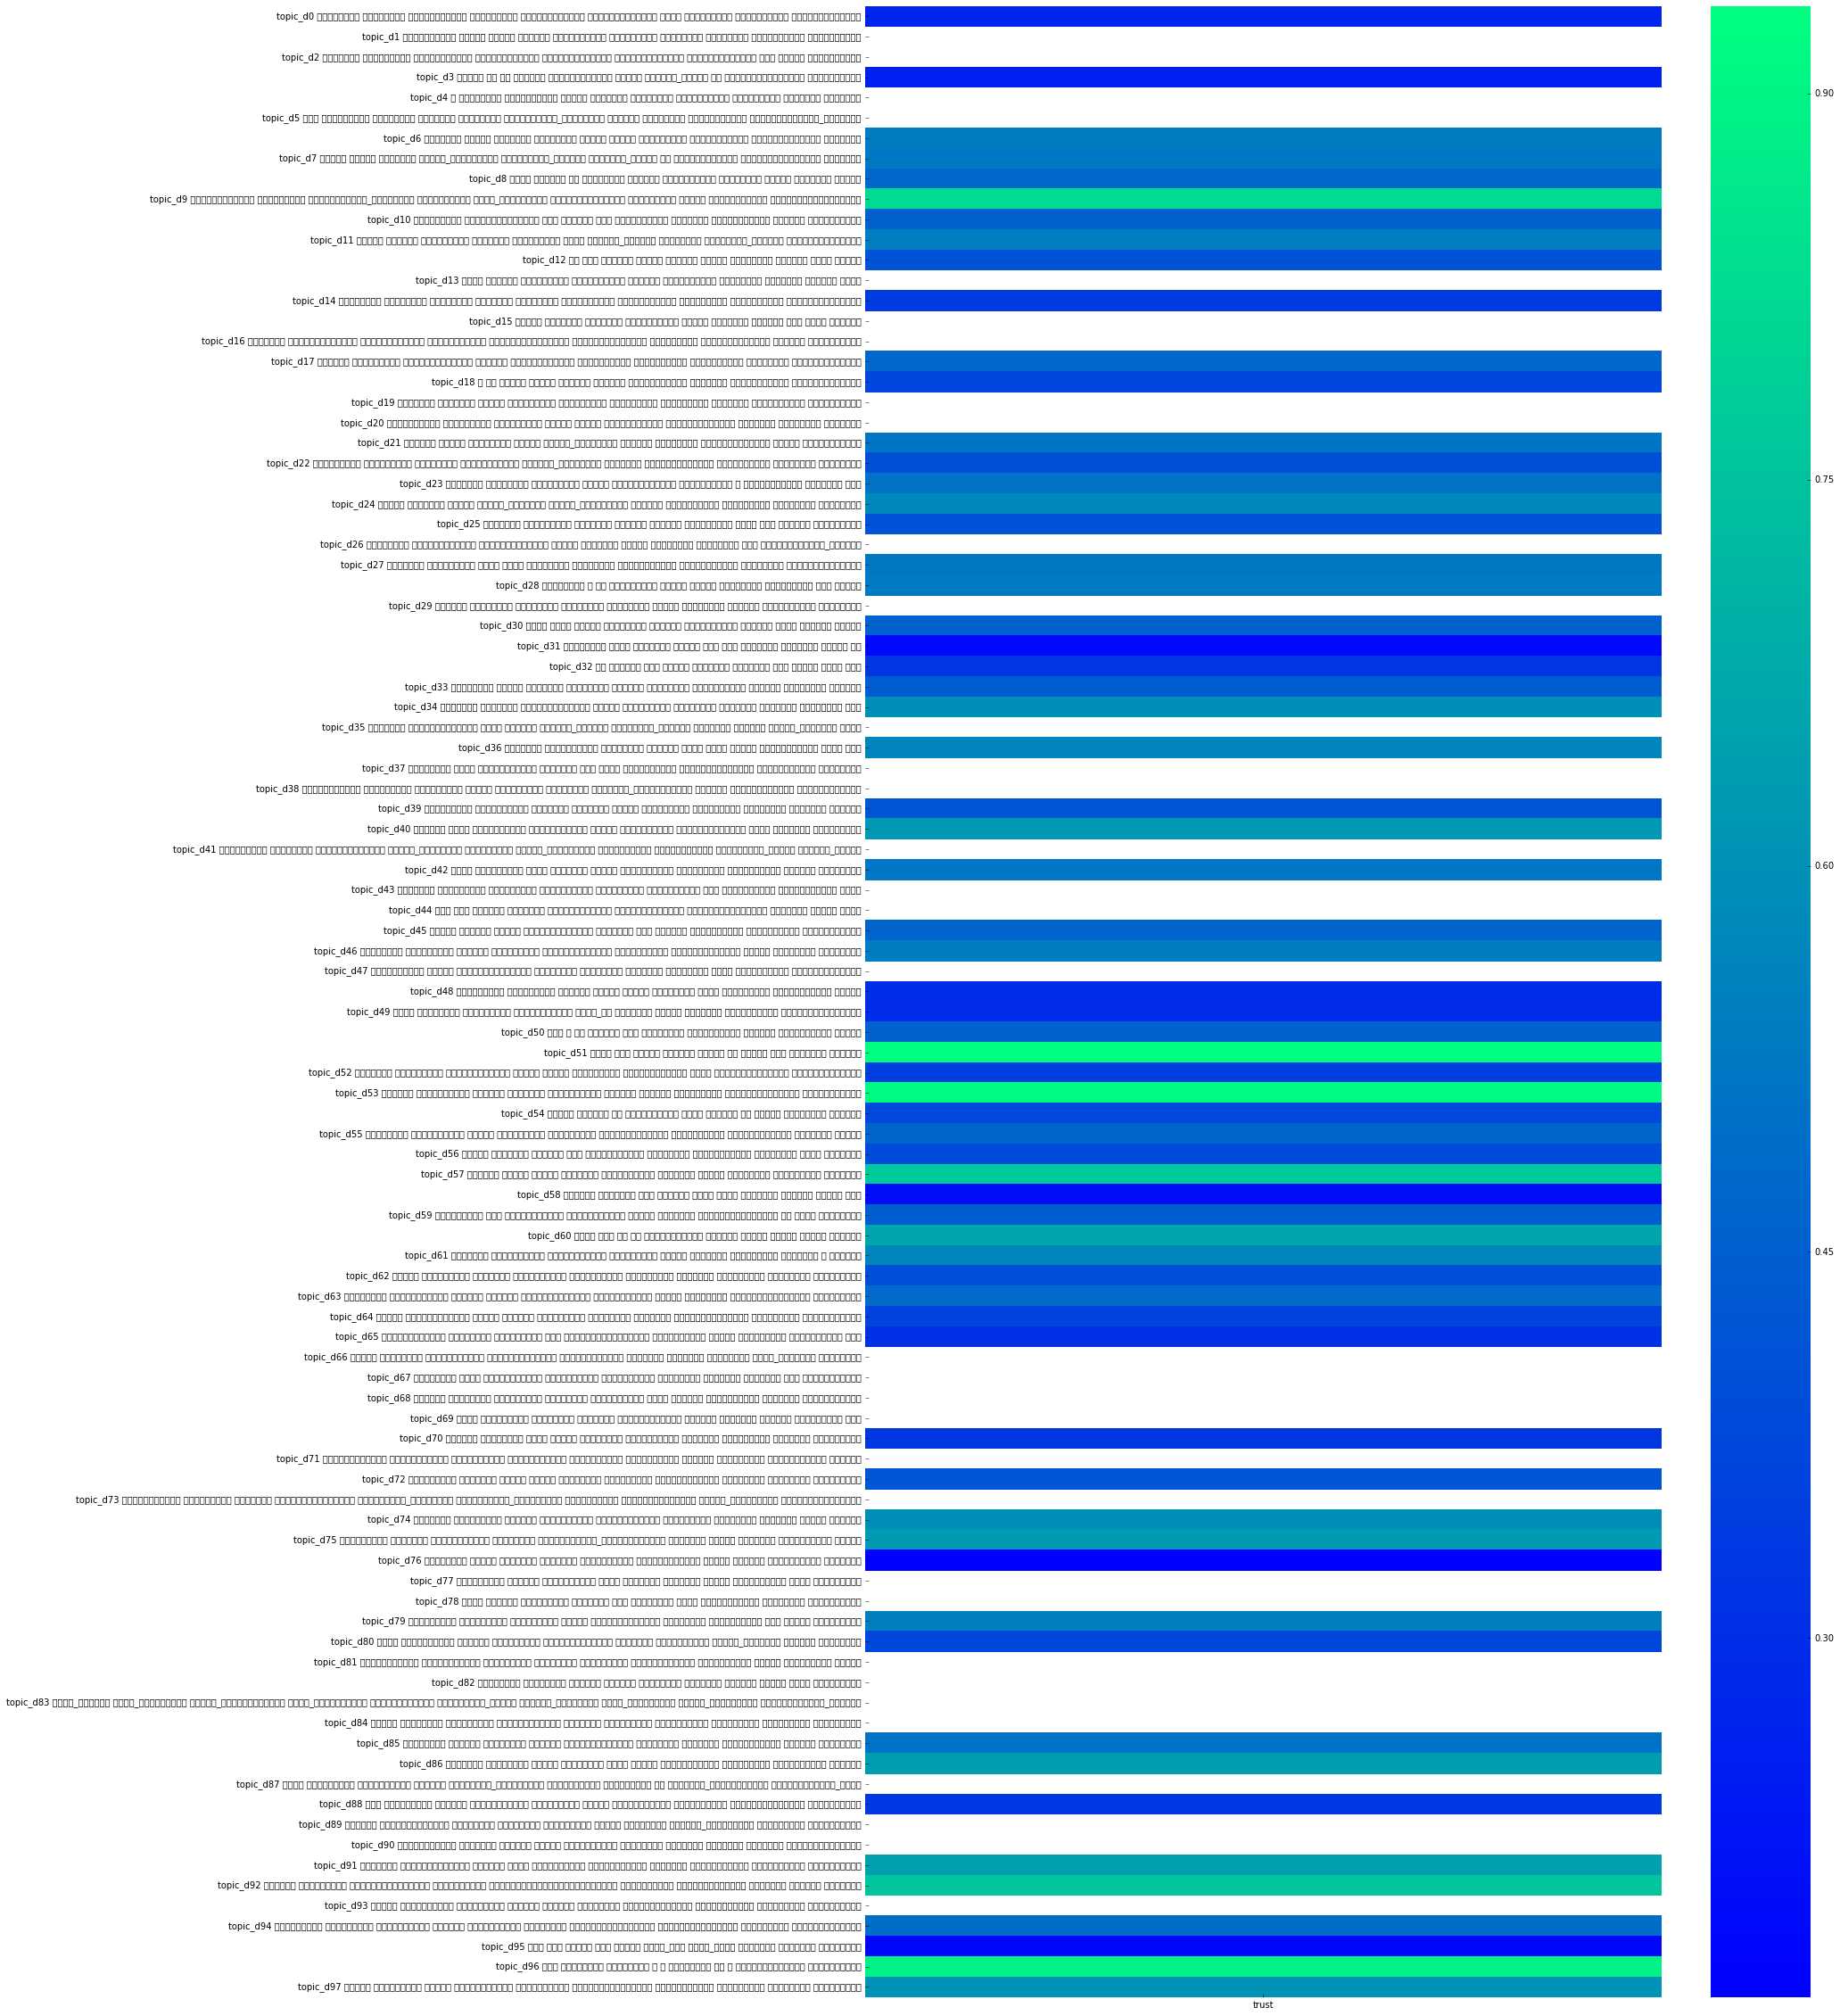

In [87]:
plt.figure(figsize=(20, 40))
data_bank = pd.DataFrame(bank_topic.transpose())
data_bank.columns = [key for key, value in sorted(banks.items(), key=lambda x:x[1]) if not_null_columns[value]]
description = []
Phi = model_vw.get_phi()
for i, topic in enumerate(topics_domain):
        topicSeries = Phi[topic].sort_values(ascending=False)[:10]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        #print " ".join(result)
        description.append(topic + " " + " ".join(result))
data_bank.index = description
heatmap(data_bank , cmap="winter")